In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
tfb = tfp.bijectors
print("TF version:", tf.__version__)
print("TFP version:", tfp.__version__)

TF version: 2.1.0
TFP version: 0.9.0


In [3]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Reshape
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# Import Fasion MNIST, make it a TensorFlow Dataset

(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.
example_x = x_test[:16]

batch_size = 64
x_train = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size)

4423680/4422102 [==============================] - 0s 0us/step


In [10]:
# Define the encoding distribution, q(z|x)
latent_size=2
event_shape=(28,28)

encoder=Sequential([Flatten(input_shape=event_shape),
                   Dense(256,activation='relu'),
                  Dense(64,activation='relu'),
                   Dense(32,activation='relu'),
                   Dense(2*latent_size),
                   tfpl.DistributionLambda(lambda t: tfd.MultivariateNormalDiag(loc=t[...,:latent_size],scale_diag=tf.math.exp(t[...,latent_size:])))])

In [11]:
# Pass an example image through the network - should return a batch of MultivariateNormalDiags.

encoder(example_x)

<tfp.distributions.MultivariateNormalDiag 'sequential_3_distribution_lambda_2_MultivariateNormalDiag' batch_shape=[16] event_shape=[2] dtype=float32>

In [12]:
# Define the decoding distribution, p(x|z)
decoder=Sequential([Dense(32,activation='relu'),
                    Dense(64,activation='relu'),
                    Dense(128,activation='relu'),
                    Dense(256,activation='relu'),
                    Dense(tfpl.IndependentBernoulli.params_size(event_shape)),
                   tfpl.IndependentBernoulli(event_shape)])
   

In [13]:
# Pass a batch of examples to the decoder

decoder(tf.random.normal([16,latent_size]))

<tfp.distributions.Independent 'sequential_4_independent_bernoulli_1_IndependentBernoulli_Independentsequential_4_independent_bernoulli_1_IndependentBernoulli_Bernoulli' batch_shape=[16] event_shape=[28, 28] dtype=float32>

In [14]:
# Define the prior, p(z) - a standard bivariate Gaussian

prior=tfd.MultivariateNormalDiag(loc=tf.zeros(latent_size))

In [28]:
# Specify the loss function, an estimate of the -ELBO

def loss_fn(x,encoding_dist,sample_decoding_dist,prior):
    return tf.reduce_sum(tfd.kl_divergence(encoding_dist,prior)-sample_decoding_dist.log_prob(x))

In [29]:
# Define a function that returns the loss and its gradients

@tf.function
def get_loss_and_grads(x):
    with tf.GradientTape() as tape:
        encoding_dist=encoder(x)
        sampled_z=encoding_dist.sample()
        sampled_decoding_dist=decoder(sampled_z)
        current_loss=loss_fn(x,encoding_dist,sampled_decoding_dist,prior)
    grad=tape.gradient(current_loss,encoder.trainable_variables+decoder.trainable_variables)
    return current_loss,grad
    

In [30]:
# Compile and train the model

num_epochs = 5
opt = tf.keras.optimizers.Adam()
for i in range(num_epochs):
    for train_batch in x_train:
        current_loss, grads = get_loss_and_grads(train_batch)
        opt.apply_gradients(zip(grads, encoder.trainable_variables
                                       + decoder.trainable_variables))
        
    print('-ELBO after epoch {}: {:.0f}'.format(i+1, current_loss.numpy()))

-ELBO after epoch 1: 9113
-ELBO after epoch 2: 8943
-ELBO after epoch 3: 8801
-ELBO after epoch 4: 8818
-ELBO after epoch 5: 8726


In [34]:
# Connect encoder and decoder, compute a reconstruction

def vae(inputs):
    approx_posterior=encoder(inputs)
    decoding_dist=decoder(approx_posterior.sample())
    return decoding_dist.mean()

In [35]:
example_reconstruction=vae(example_x).numpy().squeeze()

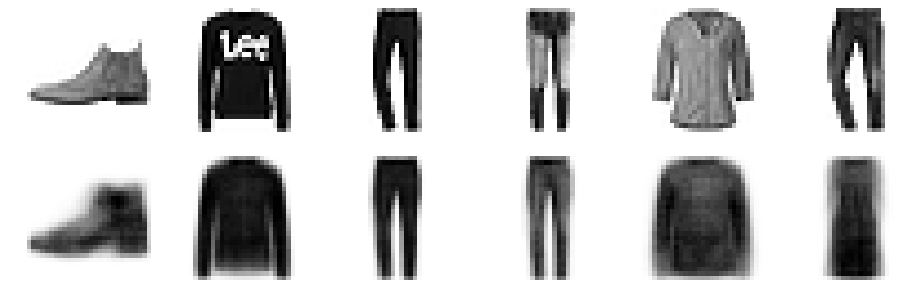

In [36]:
# Plot examples against reconstructions

f, axs = plt.subplots(2, 6, figsize=(16, 5))

for j in range(6):
    axs[0, j].imshow(example_x[j, :, :].squeeze(), cmap='binary')
    axs[1, j].imshow(example_reconstruction[j, :, :], cmap='binary')
    axs[0, j].axis('off')
    axs[1, j].axis('off')

In [42]:
# Generate an example - sample a z value, then sample a reconstruction from p(x|z)

z=prior.sample(6)
generated_x=decoder(z).mean()

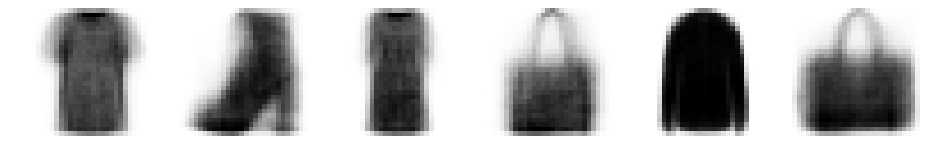

In [43]:
# Display generated_x

f, axs = plt.subplots(1, 6, figsize=(16, 5))
for j in range(6):
    axs[j].imshow(generated_x[j, :, :].numpy().squeeze(), cmap='binary')
    axs[j].axis('off')

In [44]:
# -ELBO estimate using an estimate of the KL divergence

def loss(x, encoding_dist, sampled_decoding_dist,
         prior, sampled_z):
    recon_loss = -sampled_decoding_dist.log_prob(x)
    kl_approx = (encoding_dist.log_prob(sampled_z)
                    - prior.log_prob(sampled_z))
    return tf.reduce_sum(kl_approx + recon_loss)